# BEE 4750 Homework 3: Uncertain Sea-Level Rise and Levee Reliability

**Name**: Emma Rose Connolly

**ID**: erc76

> **Due Date**
>
> Friday, 10/06/23, 9:00pm

## Overview

### Instructions

This assignment asks you to conduct a Monte Carlo analysis of levee
reliability in the face of uncertain changes to local sea levels. You
will propagate uncertainty in equilibrium climate sensitivity through
the energy balance model to obtain a distribution of temperatures, which
will then drive a model of sea-level rise. You will finally use this
distribution to assess the probability that a planned levee will achieve
its desired reliability standard.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [64]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/classes/Semester 5/BEE 4750/homework/hw3-Erc03`


In [65]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames
using Statistics

## Problems (Total: 40 Points)

### Problem 1 (12 points)

Recall from class that the simple energy balance model (EBM) of
planetary energy balance links changes in radiative forcing ($F$) to
global mean temperature ($T$) changes through the discretized equation
$$T_{i+1} = T_{i} + \frac{F_i - \lambda T_i}{cd} \times \Delta t,$$
where $i$ is the current time step, $c = 4.184 \times 10^6$
J/K/m<sup>2</sup> is the heat capacity of water per unit area, $d$ is
the (uncertain) depth of the mixing layer, $\Delta t$ is the annual time
step in seconds and $\lambda = F_{\text{2xCO}_2}/S$ is the climate
feedback parameter in W/m<sup>2</sup>/$^\circ$ C, where $S$ is the
equilibrium climate sensitivity (the uncertain equilibrium temperature
change resulting from a doubling of atmospheric CO<sub>2</sub>).
Finally, while total radiative forcing can be the result of non-aerosol
and aerosol effects, we do not know the relative intensity of aerosol
forcing, so we represent this with an uncertain aerosol scaling factor
$\alpha$.

We can implement this model with the following Julia function. We will
assume an ocean mixing depth $d = 100$ m and an aerosol scaling factor
$\alpha = 1.3$ so we can focus on the uncertainty in $S$.

The last technical concern is that “global mean temperature” does not
make sense in absolute terms as a marker of climate change. Instead, we
typically refer to temperature changes relative to some historical
pre-industrial baseline. In this case, we will use the period from
1880-1900, though this choice can vary.

In [66]:
# we need to split up the aerosol and non-aerosol forcings when we call the function
function energy_balance_model(S, forcing_aerosol, forcing_non_aerosol)
    d = 100 # ocean mixing depth [m]
    α = 1.3 # aerosol scaling factor
    F2xCO₂ = 4.0 # radiative forcing [W/m²] for a doubling of CO₂
    λ = F2xCO₂/S
    
    c = 4.184e6 # heat capacity/area [J/K/m²]
    C = c*d # heat capacity of mixed layer (per area)

    F = forcing_non_aerosol + α*forcing_aerosol # radiative forcing

    Δt = 31558152.0 # annual timestep [s]
    
    T = zero(F)
    for i in 1:length(F)-1
        T[i+1] = T[i] + (F[i] - λ*T[i])/C * Δt
    end
    # return temperature anomaly relative to 1880-1900 baseline
    return T .- mean(T[1:21]) 
end

energy_balance_model (generic function with 1 method)

Finally, we need to load some radiative forcing data. We will use the
radiative forcing scenario RCP 8.5. We can load this data, which is in a
`.csv` (comma-delimited) file, into a `DataFrame`, which is a tabular
data structure. Rows and columns in a `DataFrame` can be accessed using
their numerical index (like a matrix), but columns also have names; you
can access a particular column in a dataframe `df` by name using
`df.colname` or `df[:, "colname"]`.

Of note: this data set goes from 1750–2500, so you will need to take
care to make sure you are using the right years at each step. For
example, here we will constrain the data to 1880–2100, which is the
period we are interested in.

In [67]:
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all_85 = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# get the years corresponding to the forcings
t = Int64.(forcings_all_85[!,"year"]) # Ensure that years are interpreted as integers
# find the indices of the years 1880 and 2100
# we can do this with the indexin function
time_bounds = indexin([1880, 2100], t)
years = time_bounds[1]:time_bounds[2] # create range of years

# Separate out the individual components
forcing_co2_85 = forcings_all_85[years,"co2"]
# Get total aerosol and non-aerosol forcings
forcing_aerosol_rad_85 = forcings_all_85[years,"aerosol-radiation_interactions"]
forcing_aerosol_cloud_85 = forcings_all_85[years,"aerosol-cloud_interactions"]
forcing_aerosol_85 = forcing_aerosol_rad_85 + forcing_aerosol_cloud_85 # aerosol forcings
forcing_total_85 = forcings_all_85[years,"total"] 
forcing_non_aerosol_85 = forcing_total_85 - forcing_aerosol_85 # non-aerosol forcings

221-element Vector{Float64}:
  0.42741479112315905
  0.4487940147601447
  0.4900144276528058
 -0.019811270078689047
 -1.480725700367619
 -0.3154905163510021
  0.233186559774844
  0.2923308952663089
  0.45833872365810924
  0.5168189581089915
  ⋮
  9.879065698371564
  9.946850640754889
 10.002169546141578
 10.061009359425011
 10.115684195707905
 10.182946497594184
 10.249699157847772
 10.331407709334023
 10.424544495740134

For this assignment, you can use the `forcing_aerosol_85` and
`forcing_non_aerosol_85` vectors as is to correspond to the relevant
forcings. You will need to use the vector `t` to find the appropriate
years for analysis.

#### Problem 1.1 (3 points)

Assume that $S$ is distributed according to
$\text{LogNormal}(\log(3.2), \log{2}/3)$ (as in class). Draw 10,000
samples from this distribution and make a histogram.

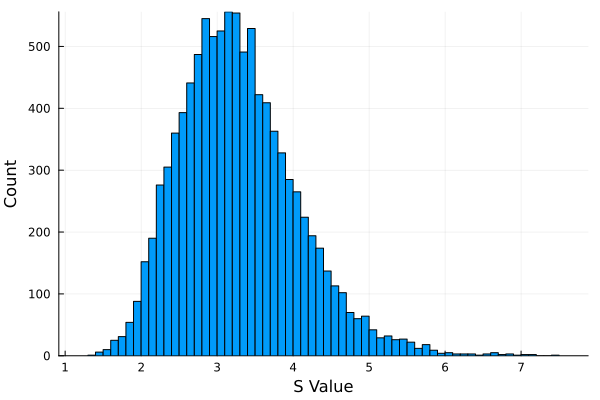

In [68]:
mu = log(3.2) #mean
sig = log(2)/3 #standard deviation
Sdist = LogNormal(mu,sig) #distribution, as described in problem

S = []
for i in 1:10000
    sval = rand(Sdist)
    S = append!(S,sval)
end

#plotting
histogram(S, legend=:false, bins=100)
xlabel!("S Value")
ylabel!("Count")

#### Problem 1.2 (5 points)

Use the EBM to propagate your samples of $S$ to a distribution of global
mean temperature. Plot the median and 90% predictive distribution
(between the .05 and .95 quantiles) from 1880-2100.

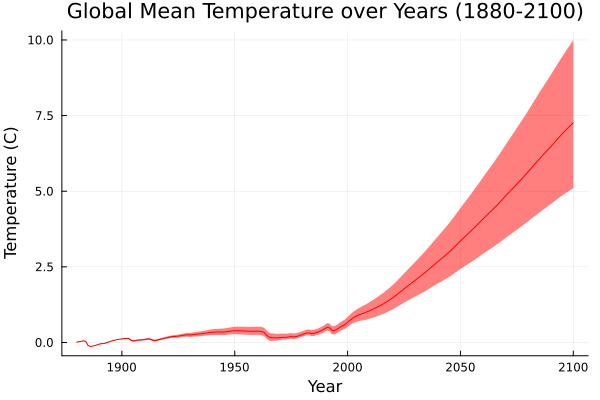

In [69]:
years = []
for i in 1880:1:2100
    append!(years,i)
end

#make an empty matrix with rows = length of S and col = length of years
globaltemperatures = zeros((length(S)),length(years))

#iterating through to have EBM for samples of S for all years
for (i,S) in pairs(S)
    globaltemperatures[i,:] = energy_balance_model(S, forcing_aerosol_85, forcing_non_aerosol_85)

end

# find median of globaltemperatures for each year/column
tempmedian = quantile.(eachcol(globaltemperatures), 0.5)

# find 0.05 quantile of globaltemperatures for each year/column
temp5 = quantile.(eachcol(globaltemperatures), 0.05)

# find 0.95 quantile of globaltemperatures for each year/column
temp95 = quantile.(eachcol(globaltemperatures), 0.95)

#plotting
plot(years, tempmedian, ribbon=(tempmedian - temp5,
    temp95 - tempmedian),legend=false,color="red")
xlabel!("Year")
ylabel!("Temperature (C)")
title!("Global Mean Temperature over Years (1880-2100)")



#### Problem 1.3 (4 points)

Make a histogram of global mean temperature projections in 2100. If you
compare this distribution to the distribution of $S$ from Problem 1.1,
what do you observe?

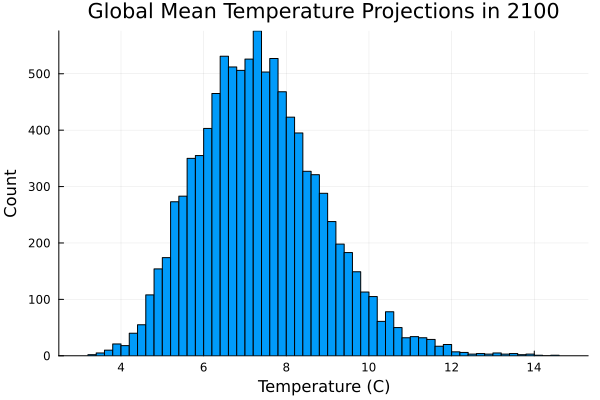

In [70]:
year2100 = globaltemperatures[:,length(years)]

#plotting
histogram(year2100, legend=:false, bins=100)
xlabel!("Temperature (C)")
ylabel!("Count")
title!("Global Mean Temperature Projections in 2100")

For this histogram, I chose to use a bins size of 100. I chose this bins size for multiple reasons, including the Law of Large Numbers and the comparison to 1.1. The Law of Large Numbers states that the more samples, or numbers, used, the more accurate you sample is. Therefore, a larger bins size would provide a more accurate demonstration of normal distribution. Assitionally, because the histogram in 1.1 has bins size of 100, then it is easier to make a direct comparison to the 1.1 histogram. 

When comparing the two historgrams, the main difference I see is there is a larger range of values in the x-axis for the 1.3 histogram. 1.1 has a range between 0 and 8 and 1.3 has a range between 0 and 14. The shape of both are approximately the same, and the count for the optimal values is about the same (approx. count of 550).  

### Problem 2 (15 points)

Changes to global temperatures cause changes in global sea levels
through several mechanisms, including thermal expansion (the change in
ocean volume due to increased heat content) and melting land-based ice.
One simple way to represent this link is through the following model,
proposed by [Rahmstorf (2007)](https://doi.org/10.1126/science.1135456).

$$\frac{dH}{dt} = a(T-T_0),$$

where $H$ is the global mean sea level in mm, $T$ is global mean
temperature, $T_0$ is an equilibrium temperature (where there is no
change in sea levels), and $a$ is a proportionality constant. This model
can be discretized to give $$H_{i+1} - H_i = a (T_i - T_0).$$

Note that, like with global mean temperature, the notion of “global mean
sea level” does not make sense in absolute terms (were sea levels ever
at “zero”?). Instead, we want to normalize this relative to some
historical baseline. In this case (with a view towards Problem 3), we
will compute our sea levels relative to the 2010 sea level. Note that in
addition to the model parameters, we also need an initial sea-level
parameter $H_0$ which will give us the right anomaly level.

The best estimates for these parameters are:

-   $a = 1.86$;
-   $H_0 = -223$;
-   $T_0 = -0.62$

#### Problem 2.1 (5 points)

Write a function `sea_level_model()` to implement the mathematical
sea-level rise model described above. It should take in needed
parameters and a vector of temperatures and return a vector of sea
levels. To test your function, use the provided temperature series
`historical_temps` (read in below) to compute the global mean sea level
anomaly in 2022 (the last year of the dataset) with the parameter values
above; you should get a value of approximately 43mm.

In [71]:
historical_temp_data = CSV.read("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv", DataFrame, delim=",")
# column 2 is the temperature anomaly, column 1 is the year
temp_bds = indexin([1880, 1900], historical_temp_data[!, 1]) # find the index of 2010 for normalization
historical_temp_data[:, 2] .-= mean(historical_temp_data[temp_bds[1]:temp_bds[2], 2])
historical_temps = historical_temp_data[temp_bds[1]:end, 2]

143-element Vector{Float64}:
  0.07297116761904765
  0.15655772761904765
  0.09327316761904769
  0.04232884761904765
 -0.10351681238095234
 -0.08232033238095232
 -0.03210037238095231
 -0.10998251238095236
  0.00942435761904764
  0.13890768761904768
  ⋮
  1.0616748976190478
  1.2139176176190476
  1.3217303776190477
  1.2339774976190476
  1.1514572476190477
  1.2798758476190477
  1.3115970476190477
  1.1506591476190478
  1.1896871476190476

In [72]:
function sea_level_model(a, H0, T0, T)
    lengthH = length(T)+1
    H=zeros(lengthH) #create an empty array for sea levels
    H[1]=H0
    for i in 2:length(T)+1    
        H[i] = H[i-1]+(a*(T[i-1]-T0))
    end
    return H[2:end] .- H[132] 
end

sea_level_model (generic function with 1 method)

In [73]:
#testing the function
#givens
a = 1.86
H0 = 223 #reconfigure and make a float 
T0 = -0.62
H = sea_level_model(a,H0,T0,historical_temps) #calling function

#looking at 2022
anomaly_2022 = H[length(H)]
print("The global mean sea level anomaly in 2022: ", round(anomaly_2022), "mm")

The global mean sea level anomaly in 2022: 40.0mm

#### Problem 2.2 (5 points)

Evaluate `sea_level_model()` using the projected temperature ensemble
from Problem 1. Plot the 90% projection interval of the sea levels.

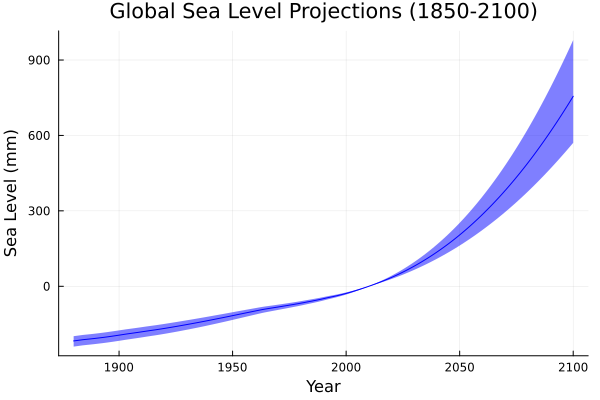

In [74]:
#Givens
a=1.86
H0=223.00
T0=-.62

#empty matrix same size of globaltemperatures
H_sea = zeros(size(globaltemperatures))

for i = 1:size(globaltemperatures)[1]
    H_sea[i,:]=sea_level_model(a,H0,T0,globaltemperatures[i,:]) #tempmedian is from problem 1
end

#creating empty matrix for quantiles
quantiles = zeros(2,length(years))


#Finding Quantiles of H_sea (for each year)
#.05 quantile
quantiles[1,:] = quantile.(eachcol(H_sea), 0.05)

#.95 Quantile
quantiles[2,:] = quantile.(eachcol(H_sea), 0.95)

# find median of H_sea for each year/column
sealevelmedian = quantile.(eachcol(H_sea), 0.5)

#plotting
plot(years, sealevelmedian, ribbon=(sealevelmedian - quantiles[1,:], quantiles[2,:] - sealevelmedian),legend=false,color="blue")

xlabel!("Year")
ylabel!("Sea Level (mm)")
title!("Global Sea Level Projections (1850-2100)")

#### Problem 2.3 (5 points)

Make a histogram of the sea-level anomaly in 2100. What can you observe
about how the ECS uncertainty has impacted sea-level uncertainty under
this radiative forcing scenario? What might the implications be of only
using the best-estimate ECS value?

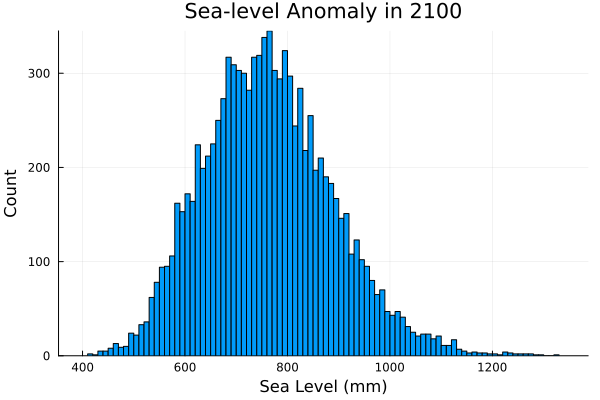

In [75]:
sealevel_2100 = H_sea[:,length(years)]
histogram(sealevel_2100, legend=:false, bins=100)
xlabel!("Sea Level (mm)")
ylabel!("Count")
title!("Sea-level Anomaly in 2100")


When comparing the sea-level anomaly in 2100 to the ECS projections in part 1.3, it is clear that they have the same distribution but have a different range (x-axis) of values. The temperature range (1.3) is significantly smaller thatn the sea level range. This means that even if the temperature range is small this can lead to a very large range in sea levels.  

### Problem 3 (13 points)

You’ve been asked to consult on a levee reliability analysis. For
context, levees in the United States are supposed to only fail once in
100 years, or, in other words, to have at most a 1% chance of failure in
a given year. We will assume for this problem that the only way in which
a levee fails is by being overtopped (note: this is unrealistic).

We can assess the probability of levee overtopping by comparing its
height to a distribution of extreme sea levels. A common approach is to
look at the distribution of the highest sea level each year. These
extreme sea levels can be obtained by combining the absolute sea level
(we will use our distribution of global sea levels for this), the rate
of subsidence (how much the ground sinks), and the distribution of storm
tides (the highest tide level, which is often the result of storm surges
combining with high tide).

Assume for this problem that:

1.  the annual rate of subsidence $\nu$ is 1.2mm/yr;
2.  the distribution of annual storm tide maxima, above the mean sea
    level, is (and is expected to continue to be) given by a
    $\text{GeneralizedExtremeValue}(900, 25, 0.3)$ distribution, which
    looks like this:

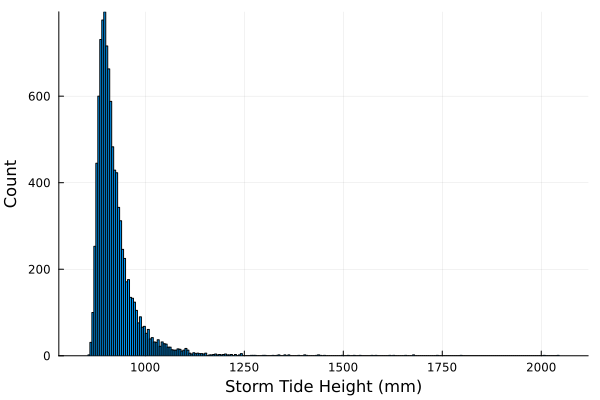

In [76]:
tide_distribution = GeneralizedExtremeValue(900, 25, 0.3)
    histogram(rand(tide_distribution, 10000), xlabel="Storm Tide Height (mm)", ylabel="Count", legend=:false)

Feel free to just sample from `tide_distribution` in your solution
below.

#### Problem 3.1 (2 points)

How would you use your sea-level simulations and the above information
to compute a distribution of extreme sea levels in 2100 relative to 2010
mean sea level? Write down the approach in clear steps, with equations
as needed.

Similar to Question 2, we will need to look at the extreme seal levels relative to 2010 mean sea level. This is done with the calculation of total subsidence. 2010 needs to be subtracted by 2100 and the annual rate of subsidence has to be multiplied by the value. Next, similar to Question 1, a random vector of 10,000 tide level samples (from tide_distribution) needs to be created. This will be added to the values from the sea-level simulation (Part 2.2) along with the total subsidence. This value provides the max sea level. From here, the historgram can be created for extreme sea levels in 2100. 

#### Problem 3.2 (3 points)

Follow the steps above and produce a histogram of the extreme sea levels
in 2100 relative to 2010.

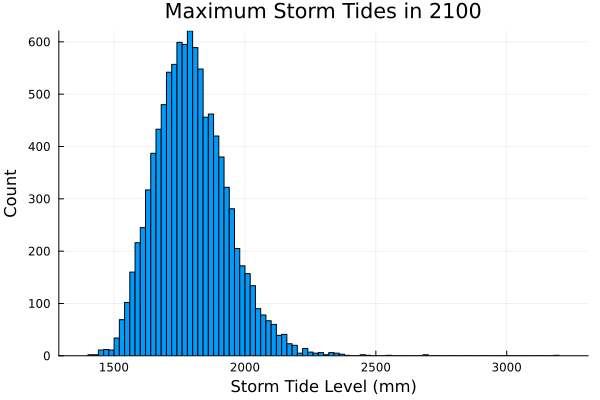

In [77]:
totalsub = (2100-2010+1)*1.2 #total subsidence 

tidemax = rand(tide_distribution,10000) #random vector of 10000 tide levels
sealevelmax = H_sea[:,end].+tidemax.+totalsub #calling back to results from 2.2 

#plotting
histogram(sealevelmax, legend=:false, bins=100)
xlabel!("Storm Tide Level (mm)")
ylabel!("Count")
title!("Maximum Storm Tides in 2100")

#### Problem 3.3 (5 points)

The current levee was heightened in 2010 to 2m above the 2010 mean sea level. Based on your analysis above, what is the probability that the levee will be overtopped in 2100 (remember that the reliability standard is 1%)?

In [78]:
overtopped = 0

#for loop to go throught all sealevelmax (10000 elements) and see how many times the max value is greater than 2000
for i in 1:length(sealevelmax)
    intsealevel = sealevelmax[i]
    if intsealevel> 2000
        global overtopped = overtopped + 1
    end
end

#what percent is above 2000 mm sea Level
probability=overtopped/length(sealevelmax)*100
print("Probability that the levee is overtopped in 2100 is: ", round(probability), "%")

Probability that the levee is overtopped in 2100 is: 8.0%

The probability that the levee being overtopped is more than the reliability standard (8% vs. 1%). This value is not  larger than the reliability standard, and it should be considered when looking at the levee height. 

#### Problem 3.4 (3 points)

Based on your analysis, would you recommend that the levee be heightened
again in the future, and if so, how high? What other information might
you need, if any, to make your recommendation?

In [79]:
leveeheight = 2000
for i in 1:100000 #arbitrary amt to go through all levee heights until prob < 1 %
    topped = 0
    #for loop to go throught all sealevelmax (10000 elements) and see how many times the topped at max levee height
    for i in 1:length(sealevelmax)
        intsealevel = sealevelmax[i]
        if intsealevel > leveeheight
            topped = topped + 1
        end
    end

    #what percent is above 2000 mm sea Level
    prob=topped/length(sealevelmax)*100

    #if loop to see is probability is less than or equal to 1
    if prob <= 1
        break
    else
        #if prob > 1 increase levee hieght
        leveeheight = leveeheight + 1
    end
end

#print statements
print("Probability that the levee is overtopped in 2100 is: ", round(prob), "%")
print("\nLevee Height is: ", leveeheight, "mm")

Probability that the levee is overtopped in 2100 is: 1.0%
Levee Height is: 2164mm

Based on my analysis, I would change the levee height to the one listed above in the output. This ensures that the probability that it is overtopped is equal to the reliability standard. Increasing the levee height will make sure that communities will not feel as effected by events that can cause devestation to places (ie. extreme storms). Some information that would need to be considered is the cost of installing a levee at the specific height. If it is too much money, a community may not be able to afford it due to budgets. Additionally, the feasibility of increasing the height of the levee needs to be considered. If the levee cannot be that high, then it cannot be done. 


## References

List any external references consulted, including classmates.

I consulted with my classmate, Teagan Smith. 